# Week 15: Poly-Square Mapping

In [3]:
import numpy as np
import matplotlib.pyplot as plt

import sys
import os
sys.path.append(os.path.abspath(os.path.join('..')))
from scipy.spatial import Delaunay
from scipy.optimize import minimize

from util.mesh.triangle.R2 import make_clockwise_2D, retrieve_boundary_angles_2D, retrieve_adjacent_vertices_with_boundary_vertex, retrieve_adjacent_vertices_with_vertex, retrieve_boundary_edges_related_vertices_2D
from util.mesh.triangle.algorithm.R2.embedding_Tutte import Tutte_embedding_2D
from util.mesh.triangle.common import retrieve_boundary_edges, retrieve_boundary_vertices
from util.util import distance_euclidean

from util.pyvista_util import preprocess, postprocess

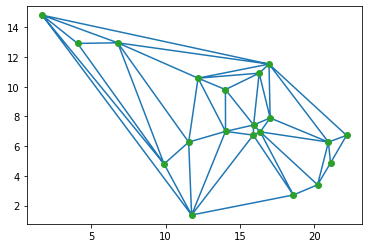

In [4]:
# 100 random points
v_num = 20
points = np.random.rand(v_num, 2)
points[:, 0]*=23
points[:, 1]*=15

# Delaunay algorithm to triangulate the mesh
tri = Delaunay(points)
make_clockwise_2D(points, tri.simplices)

plt.triplot(points[:,0], points[:,1], tri.simplices)
plt.plot(points[:,0], points[:,1], 'o')
plt.axis('equal')
plt.show()

vertices = points.copy()
faces = tri.simplices

In [6]:
class Chen_2023_scipy:
    def __init__(self, vertices, faces, lambda1=1, lambda2=1, max_iter = 100):
        self.max_iter = max_iter
        self.v_num = vertices.shape[0]
        self.vertices = vertices
        self.solution = self.vertices.copy()
        self.faces = faces
        self.J = []
        self.b = []
        
        # Hyper parameters
        self.lambda1=lambda1
        self.lambda2=lambda2
        
        # Boundary realated "BE = boundary edges" and "BV = boundary vertices"
        self.BE_r_V = retrieve_boundary_edges(faces)
        self.BV_r_V = retrieve_boundary_vertices(faces)
        self.BV_r_BV = retrieve_adjacent_vertices_with_boundary_vertex(self.BV_r_V, self.BE_r_V)
        self.BE_r_BV = retrieve_boundary_edges_related_vertices_2D(self.BV_r_V, self.BE_r_V)
        self.BV_num = len(self.BV_r_V)
    
    def activation(self, angle):
        if angle < (np.pi/2):
            return np.power(np.cos(angle), 2) / angle
        else:
            return 0
        
    def objective(self, BV):
        BV = BV.reshape((self.BV_num,2))

        E_align = 0
        E_angle = 0
        
        for i, (v1, v2) in enumerate(self.BV_r_BV):
            edge1 = BV[v1] - BV[i]
            edge2 = BV[v2] - BV[i]
            
            L1 = np.linalg.norm(edge1)
            L2 = np.linalg.norm(edge2)
            
            cos_theta = np.dot(edge1, edge2) / (L1 * L2)
            if cos_theta > 0:
                angle = np.arccos(np.clip(cos_theta, -1.0, 1.0))
                E_angle += self.activation(angle)
            
            E_align += L1*(np.sum(np.absolute(edge1/L1)) - 1) + L2*(np.sum(np.absolute(edge2/L2)) - 1)

        return E_angle + self.lambda1*E_align
    
    def mapping(self):
        self.solution = Tutte_embedding_2D(self.vertices, self.faces, self.solution[self.BV_r_V])
        
        for face in self.faces:
            A, B, C = self.solution[face]
            A_, B_, C_ = self.vertices[face]
            
            before = np.column_stack([B_-A_,C_-A_])
            after = np.column_stack([B-A,C-A])
            J_ = after @ np.linalg.inv(before)
            b_ = J_ @ B_ - B
            self.J.append(J_)
            self.b.append(b_)
            
    
    def optimize_default(self):
        x0 = np.ravel(self.solution[self.BV_r_V])
        self.res = minimize(self.objective, x0, options = {'maxiter': self.max_iter}, method = "BFGS")
        self.solution[self.BV_r_V] = self.res.x.reshape((len(self.BV_r_V) , 2))
    
    def optimize(self, iter_num):
        for i in range(iter_num):
            self.optimize_one_round()
            print("Round ", i, " done!")
    
    def optimize_one_round(self):
        x0 = np.ravel(self.solution[self.BV_r_V])
        self.res = minimize(self.objective, x0, options = {'maxiter': 1}, method = "BFGS")
        self.solution[self.BV_r_V] = self.res.x.reshape((len(self.BV_r_V) , 2))
        
    def v_plt(self, show_origin=False, show_BV=False, show_vertices=False, show_inner_edges=False, save_dict='', show_boundary_v=False):
#         plt.triplot(self.vertices[:,0], self.vertices[:,1], self.faces, label='Original Mesh', color='blue')
        if show_inner_edges:
            plt.triplot(self.solution[:,0], self.solution[:,1], self.faces, color='skyblue')
        if show_vertices:
            plt.plot(self.vertices[:,0], self.vertices[:,1], 'o')
        if show_BV:
            BV = self.solution[self.BV_r_V]
            plt.plot(BV[:,0], BV[:,1], 'o', color="green")
        if show_origin:
            for edge in self.BE_r_V:
                plt.plot(self.vertices[np.array(edge), 0], self.vertices[np.array(edge), 1], 'g-')
            plt.plot(self.vertices[np.array(self.BE_r_V[0]), 0], self.vertices[np.array(self.BE_r_V[0]), 1],label='Boundary before mapping', color='green')
            if show_inner_edges:
                plt.triplot(self.vertices[:,0], self.vertices[:,1], self.faces, color='greenyellow')
        for edge in self.BE_r_V:
            plt.plot(self.solution[np.array(edge), 0], self.solution[np.array(edge), 1], 'b-')
        plt.plot(self.solution[np.array(self.BE_r_V[0]), 0], self.solution[np.array(self.BE_r_V[0]), 1], label='Boundary after mapping', color='blue')
        if show_boundary_v:
            plt.plot(self.solution[self.BV_r_V,0], self.solution[self.BV_r_V,1], 'o')
        plt.axis('equal')
        plt.legend()
        if save_dict:
            plt.savefig(save_dict, dpi=300)
        plt.show()

In [7]:
test = Chen_2023_scipy(vertices, faces)

In [8]:
test.optimize_default()

In [9]:
test.mapping()

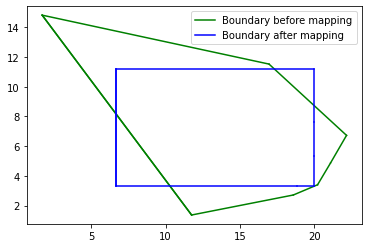

In [10]:
test.v_plt(show_origin=True, show_BV=False, show_vertices=False, show_inner_edges=False)

In [11]:
tritess_v, tritess_f = preprocess("./mesh/tritess/tritess_input.ply")
tritess_test = Chen_2023_scipy(tritess_v, tritess_f)

In [ ]:
tritess_test.optimize_default()

In [ ]:
tritess_test.v_plt(show_origin=True, show_BV=False, show_vertices=False, show_inner_edges=True)

In [28]:
cat_v, cat_f = preprocess("./mesh/cat/cat_input.ply")
cat_test = Chen_2023_scipy(cat_v, cat_f)

In [29]:
cat_test.optimize(30)

Round  0  done!
Round  1  done!
Round  2  done!
Round  3  done!
Round  4  done!
Round  5  done!
Round  6  done!
Round  7  done!
Round  8  done!
Round  9  done!
Round  10  done!
Round  11  done!
Round  12  done!
Round  13  done!
Round  14  done!
Round  15  done!
Round  16  done!
Round  17  done!
Round  18  done!
Round  19  done!
Round  20  done!
Round  21  done!
Round  22  done!
Round  23  done!
Round  24  done!
Round  25  done!
Round  26  done!
Round  27  done!
Round  28  done!
Round  29  done!


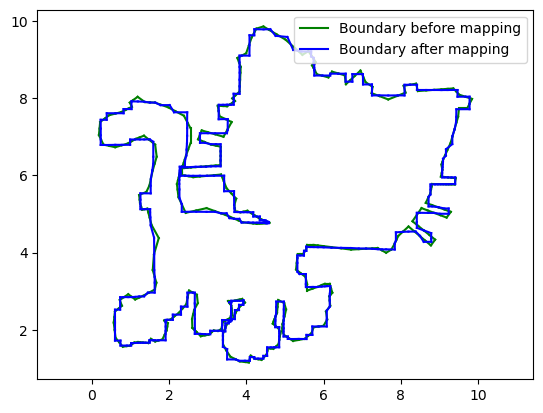

In [32]:
cat_test.v_plt(show_origin=True, show_BV=False, show_vertices=False, show_inner_edges=False)

In [33]:
cat_test.res

      fun: 4.938979209760333
 hess_inv: array([[ 1.00001488e+00,  4.62328376e-09,  2.73043028e-03, ...,
         8.04940423e-09, -1.37205365e-03,  1.37206294e-03],
       [ 4.62328376e-09,  1.00000000e+00,  6.93331202e-07, ...,
         2.05478985e-12, -3.48405744e-07,  3.48405167e-07],
       [ 2.73043028e-03,  6.93331202e-07,  9.94429442e-01, ...,
         1.89266830e-08,  2.78728330e-03, -2.79689339e-03],
       ...,
       [ 8.04940423e-09,  2.05478985e-12,  1.89266830e-08, ...,
         1.00000000e+00, -9.54513211e-09,  9.51759065e-09],
       [-1.37205365e-03, -3.48405744e-07,  2.78728330e-03, ...,
        -9.54513211e-09,  9.98605381e-01,  1.39944807e-03],
       [ 1.37206294e-03,  3.48405167e-07, -2.79689339e-03, ...,
         9.51759065e-09,  1.39944807e-03,  9.98595723e-01]])
      jac: array([-5.71608543e-04,  1.07288361e-06,  3.97857571e+00, -7.53402710e-05,
       -1.98226702e+00, -1.99637961e+00, -6.62267208e-03,  2.50339508e-05,
       -1.98913550e+00,  1.99175584e+00, -

In [34]:
postprocess("./mesh/cat/cat_output_perfect.ply", cat_test.solution, cat_test.faces)

In [35]:
cat_test.optimize_default()

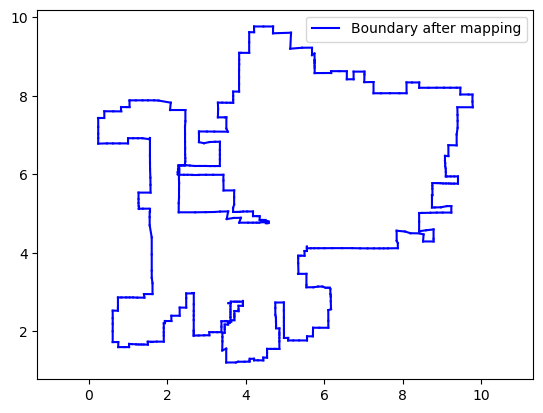

In [39]:
cat_test.v_plt(show_origin=False, show_BV=False, show_vertices=False, show_inner_edges=False)

In [40]:
postprocess("./mesh/cat/cat_output_perfect2.ply", cat_test.solution, cat_test.faces)

In [ ]:
cat_test.optimize_default()